# MaSim Analysis and Interaction

This notebook is used for testing and interacting with the output from MaSim as well as working with the input data. Once sufficiently developed, code from this notebook is converted to a Python module or script and moved into the `src/masim_analysis` or `scripts` directory. The source folder is for code that is intended to be used in other code, while the scripts folder is for code that is intended to be run from the command line. The source code may also define command line tools.

## Some constants

In [ ]:
import os
import glob
from masim_analysis import analysis

# DATA_ROOT: str = os.path.join("G:\\", "My Drive")
DATA_ROOT: str = os.path.join("/", "home", "james", "Code", "Temple-Malaria-Simulation-Analysis")
# DATA_SOURCE: str = os.path.join(DATA_ROOT, "Code", "output_old")
DATA_SOURCE: str = os.path.join(DATA_ROOT, "output2", "rwa")
filelist = glob.glob(os.path.join(DATA_SOURCE, "*.db"))

strategies = [
    "AL5",
    "AL4",
    "AL25-ASAQ75",
    "AL25-DHAPPQ75",
    "AL50-ASAQ50",
    "AL50-DHAPPQ50",
    "AL75-ASAQ25",
    "AL75-DHAPPQ25",
    "ASAQ",
    "ASAQ25-DHAPPQ75",
    "ASAQ50-DHAPPQ50",
    "ASAQ75-DHAPPQ25",
    "DHA-PPQ",
    "status_quo",
    "DHA-PPQ_3yrs_then_5day_AL50-ASAQ50",
    "DHA-PPQ_3yrs_then_AL50-DHAPPQ50",
]

Prefilter the data to clear out runs that didn't complete

In [ ]:
import shutil

for file in filelist:
    months = analysis.get_table(file, "monthlydata")
    try:
        last_month = months["id"].to_list()[-1]
    except IndexError:
        print(f"File: {file} is missing data")
        continue
    if last_month < 385:
        print(f"File: {file} is missing data for month {last_month}")
        continue
    # move the file to the correct location
    shutil.move(file, os.path.join("good", os.path.basename(file)))

## Create treatment failure plots for all strategies

Note: due to incomplete batch runs, some strategies may not have data or have incomplete data. Incomplete data will result in a ValueError when plotting due to a dimension mismatch

In [ ]:
from matplotlib import pyplot as plt

DATA_SOURCE: str = os.path.join(DATA_ROOT, "good")

for strategy in strategies:
    try:
        data = analysis.aggregate_failure_rates(DATA_SOURCE, strategy)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    if data is None:
        print(f"No data found for {strategy} or there was an aggregation error")
        continue
    try:
        fig, ax = analysis.plot_strategy_treatment_failure(data, strategy.replace("_", " ").title())
    except ValueError as e:
        print(e)
        plt.close(fig)
        continue
    plt.savefig(f"{strategy}.png")
    plt.close(fig)

## Violin plots

Create a violin plot for a given genotype based on the row in agg_fqy

In [ ]:
fig, ax = plt.subplots()
locationid = 1
for i, strategy in enumerate(strategies):
    try:
        agg_fqy = analysis.aggregate_resistant_genome_frequencies(DATA_SOURCE, strategy, "H", 325, locationid)
    except TypeError as e:
        print(e)
        continue
    except FileNotFoundError as e:
        print(e)
        continue
    except ValueError as e:
        print(e)
        continue
    except IndexError as e:
        print(e)
        continue
    try:
        ax.violinplot(agg_fqy, positions=[i], showmeans=True, orientation="horizontal")
    except Exception as e:
        print(e)
        print(f"Error plotting {strategy}")
        continue
title = "Genotype Frequencies"  # for Location {locationid}"
if locationid > 0:
    title += f" for Location {locationid}"
ax.set_title(title)
ax.set_xlabel("Frequency")
ax.set_ylabel("Strategy")
ax.set_yticks(range(len(strategies)))
ax.set_yticklabels(strategies)
plt.savefig("genotype_frequencies_violins.png")
plt.show()

Next we want to create Figure 2 from the [zubpko23 paper](https://mol.ax/pdf/zupko23b.pdf). Rather, than compare treatments, let's just do the results for one treatment per plot. 

Plot the following:
1. Number of treamtment failures plus 90% confidence interval
2. Resistant genometypes plus 90% confidence interval
3. PfPR2-10 (twelve month smoothed malaria prevelance in children 2-10 years old)

Plots are over ten years from when the treatment was started.

In [ ]:
for strategy in strategies:
    try:
        fig = analysis.plot_combined_strategy_aggragated_results(DATA_SOURCE, strategy, "H", 1)
    except Exception as e:
        print(e)
        continue
    plt.savefig(f"{strategy}_combined.png")
    plt.show()
    plt.close(fig)

## Calibration efforts

Now that we have a handle on creating the useful plots for publication we need to develop a calibration pipeline. The primary calibration point is to relate the beta parameter (rate of infection/biting) with the population size of a given map pixel. This involves a few steps. As a preliminary step, obtain the relevant raster files that contain population data, district mapping values, treatment, and beta rats (pfpr2-10, or a similar name) and place it under `data/<country>`. Calibration data will be stored under `data/<country>/calibration`.

Calibration then occurs in two phases. The first phase is generating the simulated data for beta calibration. See `scripts/calibrate.py` for an example but the general process is to use the `configure` command to create various input .yml files that vary a single pixel map's population, access rate, and beta values. The second phase is to then compare and fit this data to the real beta values.

### Raster utilities

In [ ]:
import numpy as np


def read_raster(file: str) -> np.ndarray:
    with open(file, "r") as f:
        data = f.read().splitlines()
    metadata = data[:6]
    data = data[6:]
    # convert the metadata to a dictionary
    metadata = {line.split()[0]: float(line.split()[1]) for line in metadata}
    raster = np.zeros((int(metadata["nrows"]), int(metadata["ncols"])))
    for i, line in enumerate(data):
        line = line.split()
        line = np.asarray(line, dtype=float)
        raster[i, :] = line
    # filter metadata['NODATA_value'] from the raster to be np.nan
    raster[raster == metadata["NODATA_value"]] = np.nan
    return raster, metadata

In [ ]:
districts, _ = read_raster("data/moz/moz_districts.asc")
population, _ = read_raster("data/moz/moz_population.asc")
prevalence, _ = read_raster("data/moz/moz_pfpr210.asc")
treatment, _ = read_raster("data/moz/moz_treatmentseeking.asc")

In [ ]:
import pandas as pd

district_names = pd.read_csv("data/moz/moz_mapping.csv", index_col="ID")
names = district_names.to_dict()["DISTRICT"]

#### Plot districts

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# define a custom color map for the 11 districts
cmap = plt.get_cmap("tab20", 11)
# create a new figure
fig, ax = plt.subplots()
# plot the districts raster
ax.imshow(districts, cmap=cmap)
ax.set_title("Mozambique Districts")

# create legend handles
handles = [Patch(color=cmap(i), label=names[i + 1].replace("_", " ")) for i in range(11)]
ax.legend(bbox_to_anchor=(1.75, 1), handles=handles, title="Districts", loc="upper right")

plt.show()

#### Plot population

In [ ]:
fig, ax = plt.subplots()
ax.imshow(population, cmap="coolwarm")
ax.set_title("Population")
fig.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax, label="Population Density")
plt.show()

#### Plot prevalence

This is what we'll end up calibrating too.

In [ ]:
fig, ax = plt.subplots()
ax.imshow(prevalence, cmap="coolwarm")
ax.set_title("pfpr 2-10")
fig.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=ax, label="Prevalence")
plt.show()

## Run calibration

The unknown that we are trying to solve for is the beta value(s). We have _real_ pixel-wise _prevalence_ (pfpr2-10) data that arrises from a given beta. The goal is to generate data that matches closely the real prevalence data by varying the beta value, population size, and access rate for a simulated single pixel. We will first generate the configuration files for the calibration runs here. The below cell is also in the `scripts/calibrate.py` script.

In [1]:
# Country calibration script
from masim_analysis import configure
from datetime import date
import os

from ruamel.yaml import YAML

yaml = YAML()

# Calibration parameters
populations = [10, 25, 50, 75, 100, 150, 200, 250, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 7500, 10000, 12500, 15000, 20000]
betas = [0.001, 0.005, 0.01, 0.0125, 0.015, 0.02, 0.03, 0.04, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1]
access_rates = [0.50, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
calibration_year = 2022 # This is the year from which we have pfpr data
# Input parameters
name = "moz"
comparison = date(calibration_year, 1, 1)
start = date(calibration_year - 11, 1, 1)
end = date(calibration_year + 1, 12, 31)
birth_rate = 31.2 / 1000
death_rate = [0.049744, 0.064331, 0.064331, 0.064331, 0.064331, 0.00359, 0.00361, 0.00365, 0.00379, 0.00379, 0.133, 0.133, 0.0174, 0.0174 ]
age_distribution = [ 0.037, 0.132, 0.161, 0.142, 0.090, 0.086, 0.070, 0.052, 0.044, 0.044, 0.031, 0.041, 0.024, 0.017, 0.013, 0.017 ]

In [2]:
from tqdm import tqdm
### Execution ------------------------------------------------
execution_control = configure.main(
    name,
    start.strftime("%Y/%m/%d"),
    end.strftime("%Y/%m/%d"),
    comparison.strftime("%Y/%m/%d"),
    calibration=True,
)
execution_control["birth_rate"] = birth_rate
execution_control["death_rate"] = death_rate
execution_control["age_distribution"] = age_distribution
execution_control["strategy_db"] = {
    0: {
        "name": "baseline",
        "type": "MFT",
        "therapy_ids": [0],
        "distribution": [1],
    },
}
execution_control["initial_strategy_id"] = 0

execution_control["events"] = [
    {"name": "turn_off_mutation", "info": [{"day": start.strftime("%Y/%m/%d")}]},
]

for pop in tqdm(populations):
    for access in access_rates:
        for beta in betas:
            execution_control["raster_db"] = configure.validate_raster_files(
                "moz",
                calibration=True,
                calibration_string=f"{pop}_{access}_{beta}",
                access_rate=access,
                age_distribution=age_distribution,
                beta=beta,
                population=pop,
            )
            output_path = os.path.join("conf", name, "calibration", f"cal_{pop}_{access}_{beta}.yml")
            yaml.dump(execution_control, open(output_path, "w"))

100%|██████████| 22/22 [15:58<00:00, 43.56s/it]


Use the command line tool to generate the calibration command and job files for use on the cluster.

In [4]:
generate-commands -i conf/moz/calibration -o conf/moz/calibration -r 20

SyntaxError: invalid syntax (478281459.py, line 1)

### Load simulated data

In [2]:
from masim_analysis import analysis
import pandas as pd

base_file_path = os.path.join("output", name, "calibration")
summary = pd.DataFrame(columns=["population", "access_rate", "beta", "iteration", "pfprunder5", "pfpr2to10", "pfprall"])

year_start = comparison.strftime("%Y-%m-%d")
year_end = (comparison + pd.DateOffset(years=1)).strftime("%Y-%m-%d")

for pop in populations:
    for access in access_rates:
        for beta in betas:
            for i in range(10):       
                filename = f"cal_{pop}_{access}_{beta}_monthly_data_{i}"
                file = os.path.join(base_file_path, f"{filename}.db") 
                
                try:
                    months = analysis.get_table(file, "monthlydata")
                    monthlysitedata = analysis.get_table(file, "monthlysitedata")
                except FileNotFoundError as e:
                    print(e)
                    continue
                data = pd.merge(monthlysitedata, months, left_on="monthlydataid", right_on="id")
                data['date'] = pd.to_datetime(data['modeltime'], unit='s')

                summary.loc[filename] = data[(data['date'] >= comparison.strftime("%Y-%m-%d")) & (data['date'] < year_end)][['pfprunder5', 'pfpr2to10', 'pfprall']].mean()
                summary.loc[filename, "population"] = pop
                summary.loc[filename, "access_rate"] = access
                summary.loc[filename, "beta"] = beta
                summary.loc[filename, "iteration"] = int(i)

summary.to_csv(f"{base_file_path}/calibration_summary.csv")
summary

File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_0.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_1.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_2.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_3.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_4.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_5.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_6.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_7.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_8.db
File not found: output/moz/calibration/cal_10_0.5_0.001_monthly_data_9.db
File not found: output/moz/calibration/cal_10_0.5_0.005_monthly_data_0.db
File not found: output/moz/calibration/cal_10_0.5_0.005_monthly_data_1.db
File not found: output/moz/calibration/cal_10_0.5_0.005_monthly_data_2.db
File not found: output/moz/calibration

,population,access_rate,beta,iteration,pfprunder5,pfpr2to10,pfprall
cal_10_0.55_0.001_monthly_data_0,10.0,0.55,0.001,0.0,0.0,0.0,0.0
cal_10_0.55_0.001_monthly_data_1,10.0,0.55,0.001,1.0,0.0,0.0,0.0
cal_10_0.55_0.001_monthly_data_2,10.0,0.55,0.001,2.0,0.0,0.0,0.0
cal_10_0.55_0.001_monthly_data_3,10.0,0.55,0.001,3.0,0.0,0.0,0.0
cal_10_0.55_0.001_monthly_data_4,10.0,0.55,0.001,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
cal_100_0.75_0.01_monthly_data_5,100.0,0.75,0.010,5.0,0.0,0.0,0.0
cal_100_0.75_0.01_monthly_data_6,100.0,0.75,0.010,6.0,0.0,0.0,0.0
cal_100_0.75_0.01_monthly_data_7,100.0,0.75,0.010,7.0,0.0,0.0,0.0
cal_100_0.75_0.01_monthly_data_8,100.0,0.75,0.010,8.0,0.0,0.0,0.0


Now we'll do some basic plotting.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

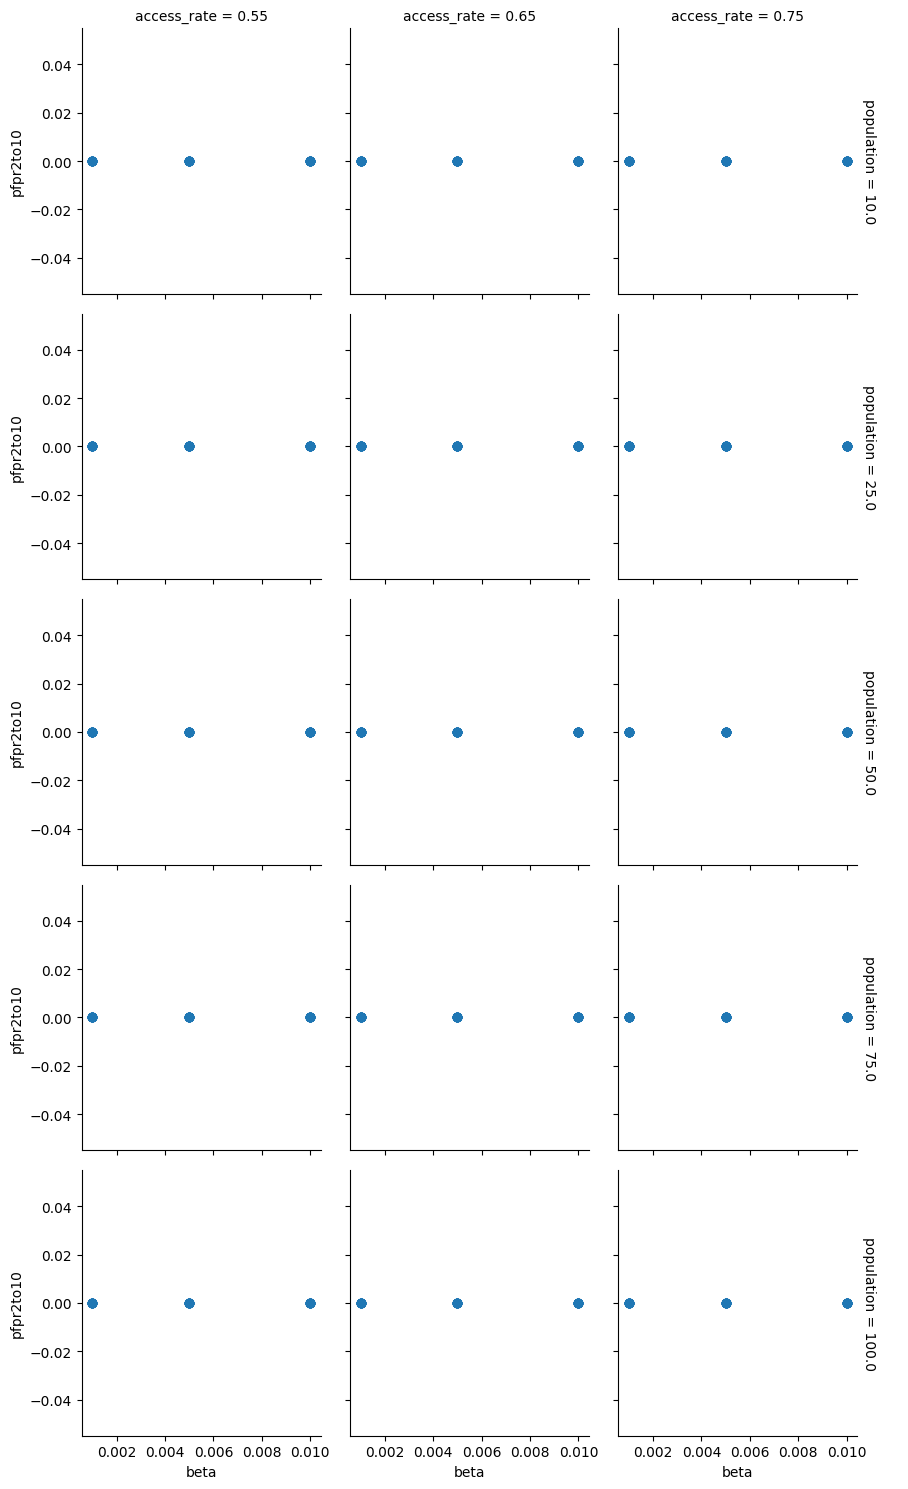

In [8]:
g = sns.FacetGrid(summary, col="access_rate", row="population", margin_titles=True)
g.map(plt.scatter, "beta", "pfpr2to10")
g.set_axis_labels
g.add_legend()
plt.show()